In [3]:
import numpy as np 
import pandas as pd
import shutil
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [1]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 60.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: brotli
    Found existing installation: Brotli 1.0.9
    Uninstalling Brotli-1.0.9:
      Successfully uninstalled Brotli-1.0.9


In [4]:
import os
files = os.listdir('/kaggle/working')

for file in files:
    file_path = os.path.join('/kaggle/working', file)
    if os.path.isfile(file_path):
        os.remove(file_path)
    else:
        shutil.rmtree(file_path)


In [5]:
from py7zr import unpack_7zarchive
# unpack_7zarchive('/kaggle/input/cifar-10/train.7z', '/kaggle/working/train')
# unpack_7zarchive('/kaggle/input/cifar-10/test.7z', '/kaggle/working/test')

import shutil

shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('/kaggle/input/cifar-10/train.7z', '/kaggle/temp/')

In [6]:
train_labels=pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv", header='infer')
print(train_labels.head(5))
print(train_labels.shape)

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
(50000, 2)


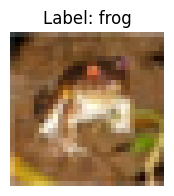

In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image
traindir = '/kaggle/temp/train'


image_filename = str(train_labels.iloc[0]['id']) + '.png'
label = train_labels.iloc[0]['label']
image_path = os.path.join(traindir, image_filename)

image = Image.open(image_path)
plt.figure(figsize=(2,2))
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
labels=train_labels.iloc[:,-1].unique()
print(labels)

name2num={}
i=0
for name in labels:
    name2num[name]=i
    i=i+1
print(name2num)
num2name={}
for i in range(len(labels)):
    num2name[i]=labels[i]
print(num2name)

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']
{'frog': 0, 'truck': 1, 'deer': 2, 'automobile': 3, 'bird': 4, 'horse': 5, 'ship': 6, 'cat': 7, 'dog': 8, 'airplane': 9}
{0: 'frog', 1: 'truck', 2: 'deer', 3: 'automobile', 4: 'bird', 5: 'horse', 6: 'ship', 7: 'cat', 8: 'dog', 9: 'airplane'}


In [ ]:
# trainlabels=pd.read_csv('/kaggle/input/cifar-10/trainLabels.csv')
# labels=trainlabels.iloc[:,-1].unique()
# print(labels)
# labels={}
# count=1
# for i in labels:
#     labels[i]=count
#     count+=1
# print(labels)
# labelid=list(labels.values())
# print(labelid)
# print(trainlabels.shape)

In [9]:
if torch.cuda.is_available():
    device=torch.device("cuda")

In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize, Resize, Compose

class TrainDataset(Dataset):
    def __init__(self, imagepath, labelpath):
        super().__init__()
        self.imgpath=imagepath
        self.labels=pd.read_csv(labelpath, header='infer')
        self.transform=Compose([Resize((224,224)), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self,index):
        finalpath=os.path.join(self.imgpath,str(index+1))+'.png'
        img=read_image(finalpath)/255
        img=self.transform(img)
        label=self.labels.iloc[index,1]
        label=name2num[label]
        return img,label


In [12]:
traindataset=TrainDataset(traindir,'/kaggle/input/cifar-10/trainLabels.csv')        
        
batch_size=64    
traindataloader=DataLoader(traindataset, batch_size)

In [13]:
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
class mobilenetv3(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        self.pretrainednet.classifier=nn.Sequential(
            nn.Linear(in_features=960, out_features=1280, 
                   bias=True),nn.Hardswish(), 
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=10, 
                      bias=True)
        )
        
    def forward(self,x):
        x=self.pretrainednet(x)
        return x


In [14]:
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=vgg16(weights=VGG16_Weights.DEFAULT)
        self.pretrainednet.classifier=nn.Sequential(
            nn.Linear(in_features=25088,out_features=4096,bias=True),
            nn.ReLU(),
            nn.Linear(in_features=4096,out_features=4096,bias=True),
            nn.ReLU(),
            nn.Linear(in_features=4096,out_features=1000,bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1000,out_features=10,bias=True)
        )
    
    def forward(self,x):
        x=self.pretrainednet(x)
        return x

In [15]:
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights

class Cifar10Net(nn.Module):
    def __init__(self):
        super().__init__()
#         self.pretrainednet = resnet18(pretrained=True)
        self.pretrainednet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.pretrainednet.fc.in_features
        self.pretrainednet.fc = nn.Linear(num_features, 10)
        
    def forward(self, x):
        x = self.pretrainednet(x)
        return x


In [16]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)  
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s] 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
models_acc={}
models_loss={}

In [21]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    correct=0
    
    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)
                    
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
        
        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((correct/((i*batch_size+imgs.shape[0])))*100,2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)
            
    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

In [23]:
model = Cifar10Net()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
epochs = 10

print("Training the newly added layers first")

for i in range(epochs):
    print("Epoch:", i+1)
    train_epoch_loss, train_epoch_acc = train_one_epoch(traindataloader, model, loss_fn, optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")


Training the newly added layers first
Epoch: 1
Batch: 1 / 782 Running Loss: 2.68 Running Accuracy: 4.69
Batch: 101 / 782 Running Loss: 0.91 Running Accuracy: 68.89
Batch: 201 / 782 Running Loss: 0.78 Running Accuracy: 73.24
Batch: 301 / 782 Running Loss: 0.71 Running Accuracy: 75.83
Batch: 401 / 782 Running Loss: 0.65 Running Accuracy: 77.61
Batch: 501 / 782 Running Loss: 0.62 Running Accuracy: 78.83
Batch: 601 / 782 Running Loss: 0.59 Running Accuracy: 79.78
Batch: 701 / 782 Running Loss: 0.57 Running Accuracy: 80.58
Training: Epoch Loss: 0.56 Epoch Accuracy: 81.04
--------------------------------------------------
Epoch: 2
Batch: 1 / 782 Running Loss: 0.29 Running Accuracy: 92.19
Batch: 101 / 782 Running Loss: 0.36 Running Accuracy: 87.86
Batch: 201 / 782 Running Loss: 0.35 Running Accuracy: 88.14
Batch: 301 / 782 Running Loss: 0.34 Running Accuracy: 88.51
Batch: 401 / 782 Running Loss: 0.33 Running Accuracy: 88.87
Batch: 501 / 782 Running Loss: 0.32 Running Accuracy: 89.13
Batch: 60

In [24]:
for param in model.pretrainednet.parameters():
    param.requires_grad = True

print("Fine tuning in the entire model")

acc=[]
loss=[]
for i in range(epochs):
    print("Epoch:", i + 1)
    train_epoch_loss, train_epoch_acc = train_one_epoch(traindataloader, model, loss_fn, optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")
    acc.append(train_epoch_acc)
    loss.append(train_epoch_loss)

Fine tuning in the entire model
Epoch: 1
Batch: 1 / 782 Running Loss: 0.24 Running Accuracy: 95.31
Batch: 101 / 782 Running Loss: 0.09 Running Accuracy: 96.86
Batch: 201 / 782 Running Loss: 0.08 Running Accuracy: 97.16
Batch: 301 / 782 Running Loss: 0.09 Running Accuracy: 97.1
Batch: 401 / 782 Running Loss: 0.09 Running Accuracy: 96.88
Batch: 501 / 782 Running Loss: 0.09 Running Accuracy: 96.91
Batch: 601 / 782 Running Loss: 0.09 Running Accuracy: 96.83
Batch: 701 / 782 Running Loss: 0.09 Running Accuracy: 96.91
Training: Epoch Loss: 0.09 Epoch Accuracy: 96.98
--------------------------------------------------
Epoch: 2
Batch: 1 / 782 Running Loss: 0.08 Running Accuracy: 96.88
Batch: 101 / 782 Running Loss: 0.08 Running Accuracy: 97.22
Batch: 201 / 782 Running Loss: 0.08 Running Accuracy: 97.43
Batch: 301 / 782 Running Loss: 0.08 Running Accuracy: 97.22
Batch: 401 / 782 Running Loss: 0.08 Running Accuracy: 97.19
Batch: 501 / 782 Running Loss: 0.08 Running Accuracy: 97.27
Batch: 601 / 78

NameError: name 'acc' is not defined

In [30]:
models_acc['resnet']=acc
models_loss['resnet']=loss

In [36]:
modelv=VGG16().to(device)

for param in modelv.pretrainednet.features.parameters():
    param.requires_grad=True

acc=[]
loss=[]
epochs=10
for i in range(epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(traindataloader,modelv,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")
    acc.append(train_epoch_acc)
    loss.append(train_epoch_loss)
    
models_acc['VGG16']=acc
models_loss['VGG16']=loss

Epoch No: 1
Batch: 1 / 782 Running Loss: 2.31 Running Accuracy: 3.12
Batch: 101 / 782 Running Loss: 2.3 Running Accuracy: 10.19
Batch: 201 / 782 Running Loss: 2.3 Running Accuracy: 10.19
Batch: 301 / 782 Running Loss: 2.3 Running Accuracy: 10.23
Batch: 401 / 782 Running Loss: 2.3 Running Accuracy: 10.17
Batch: 501 / 782 Running Loss: 2.3 Running Accuracy: 10.15
Batch: 601 / 782 Running Loss: 2.3 Running Accuracy: 10.11
Batch: 701 / 782 Running Loss: 2.3 Running Accuracy: 10.09
Training: Epoch Loss: 2.31 Epoch Accuracy: 10.06
--------------------------------------------------
Epoch No: 2
Batch: 1 / 782 Running Loss: 2.31 Running Accuracy: 3.12
Batch: 101 / 782 Running Loss: 2.3 Running Accuracy: 10.19
Batch: 201 / 782 Running Loss: 2.3 Running Accuracy: 10.19
Batch: 301 / 782 Running Loss: 2.3 Running Accuracy: 10.23
Batch: 401 / 782 Running Loss: 2.3 Running Accuracy: 10.17
Batch: 501 / 782 Running Loss: 2.3 Running Accuracy: 10.15
Batch: 601 / 782 Running Loss: 2.3 Running Accuracy: 1

In [37]:
modelv3=mobilenetv3().to(device)

for param in modelv3.pretrainednet.features.parameters():
    param.requires_grad=True

epochs=10
acc=[]
loss=[]
for i in range(epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(traindataloader,modelv3,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")
    acc.append(train_epoch_acc)
    loss.append(train_epoch_loss)
    
models_acc['mobilenetv3']=acc
models_loss['mobilenetv3']=loss

Epoch No: 1
Batch: 1 / 782 Running Loss: 2.3 Running Accuracy: 12.5
Batch: 101 / 782 Running Loss: 2.3 Running Accuracy: 9.81
Batch: 201 / 782 Running Loss: 2.3 Running Accuracy: 9.38
Batch: 301 / 782 Running Loss: 2.3 Running Accuracy: 9.43
Batch: 401 / 782 Running Loss: 2.3 Running Accuracy: 9.24
Batch: 501 / 782 Running Loss: 2.3 Running Accuracy: 9.32
Batch: 601 / 782 Running Loss: 2.3 Running Accuracy: 9.36
Batch: 701 / 782 Running Loss: 2.3 Running Accuracy: 9.4
Training: Epoch Loss: 2.31 Epoch Accuracy: 9.41
--------------------------------------------------
Epoch No: 2
Batch: 1 / 782 Running Loss: 2.31 Running Accuracy: 7.81
Batch: 101 / 782 Running Loss: 2.3 Running Accuracy: 9.51
Batch: 201 / 782 Running Loss: 2.3 Running Accuracy: 9.31
Batch: 301 / 782 Running Loss: 2.3 Running Accuracy: 9.33
Batch: 401 / 782 Running Loss: 2.3 Running Accuracy: 9.07
Batch: 501 / 782 Running Loss: 2.3 Running Accuracy: 9.17
Batch: 601 / 782 Running Loss: 2.3 Running Accuracy: 9.25
Batch: 701 

In [ ]:
# print("for Resnet18 accuracy: ",max(model_acc['resnet']))
# print("for vgg16 accuracy: ",max(model_acc['VGG16']))
# print("for mobilenetv3 accuracy: ",max(model_acc['mobilenetv3']))

In [38]:
testdir='/kaggle/working/test'
shutil.unpack_archive('/kaggle/input/cifar-10/test.7z', testdir)
shutil.unregister_unpack_format('7zip')

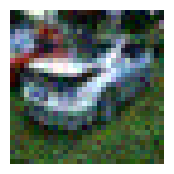

In [39]:
testdir='/kaggle/working/test/test'
image_files = os.listdir(testdir)
image_file = os.path.join(testdir, image_files[0])
image = Image.open(image_file)

plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.axis('off') 
plt.show()

In [40]:
class TestDataset(Dataset):
    def __init__(self, imgpath):
        super().__init__()
        self.imgpath=imgpath
        _,_,self.files=next(os.walk(self.imgpath))
        self.length=len(self.files)
        self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        finalpath=os.path.join(self.imgpath,str(index+1))+'.png'
        img=read_image(finalpath)/255.0
        img=self.transform(img)
        return img

testdataset=TestDataset(testdir)
testdataloader=DataLoader(dataset=testdataset, batch_size=batch_size)

In [41]:
def eval(dataloader, model,loss_fn, path):
    model.eval()
    data=pd.read_csv(path)
    with torch.no_grad():
        for i, imgs in enumerate(dataloader):
            finalbatchpred=np.zeros(imgs.shape[0],dtype='object')
            imgs=imgs.to(device)
            pred=model(imgs)
            
            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            for j,p in enumerate(pred):
                finalbatchpred[j]=num2name[p.item()]
            data.iloc[i*batch_size:i*batch_size+batch_size ,1]=finalbatchpred
    
    data.to_csv('submission.csv', index=False)
    print(data.head(10))

In [42]:
eval(testdataloader, model,loss_fn, '/kaggle/input/cifar-10/sampleSubmission.csv')

   id     label
0   1     horse
1   2      deer
2   3  airplane
3   4  airplane
4   5      deer
5   6      deer
6   7      ship
7   8      deer
8   9       dog
9  10      deer


In [43]:
df=pd.read_csv('submission.csv')
df.head(5)

,id,label
0,1,horse
1,2,deer
2,3,airplane
3,4,airplane
4,5,deer
